In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/weights-densenet/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5
/kaggle/input/weights-mobilenet/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5
/kaggle/input/weights-resne50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
/kaggle/input/voc2008/VOC2008/SegmentationObject/2007_004121.png
/kaggle/input/voc2008/VOC2008/SegmentationObject/2007_005828.png
/kaggle/input/voc2008/VOC2008/SegmentationObject/2008_005938.png
/kaggle/input/voc2008/VOC2008/SegmentationObject/2007_006647.png
/kaggle/input/voc2008/VOC2008/SegmentationObject/2007_009088.png
/kaggle/input/voc2008/VOC2008/SegmentationObject/2007_004275.png
/kaggle/input/voc2008/VOC2008/SegmentationObject/2007_000241.png
/kaggle/input/voc2008/VOC2008/SegmentationObject/2007_005281.png
/kaggle/input/voc2008/VOC2008/SegmentationObject/2007_008430.png
/kaggle/input/voc2008/VOC2008/SegmentationObject/2007_007748.png
/kaggle/input/voc2008/VOC2008/SegmentationObject/2007_005273.png
/kaggle/input/voc

In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [6]:
DATA_DIR = '/kaggle/input/voc2008/VOC2008'
JPEG_IMAGES_DIR = os.path.join(DATA_DIR, 'JPEGImages')
IMAGESETS_MAIN_DIR = os.path.join(DATA_DIR, 'ImageSets', 'Main')

In [7]:
VOC_CLASSES = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
    'bus', 'car', 'cat', 'chair', 'cow',
    'diningtable', 'dog', 'horse', 'motorbike', 'person',
    'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

In [8]:
BATCH_SIZE = 16
IMG_SIZE = (224, 224)
NUM_EPOCHS = 30  
LEARNING_RATE = 0.001

In [10]:
def build_labels_dict(split='train'):
    """
    Build a dictionary mapping each image ID to a multi-label vector of length 20.
    It reads per-class label files (e.g., aeroplane_train.txt) from IMAGESETS_MAIN_DIR.
    """
    labels_dict = {}
    for class_idx, cls in enumerate(VOC_CLASSES):
        file_path = os.path.join(IMAGESETS_MAIN_DIR, f"{cls}_{split}.txt")
        with open(file_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                image_id = parts[0]
                # +1 indicates presence; any other value is considered absent.
                label = 1 if int(parts[1]) == 1 else 0
                if image_id not in labels_dict:
                    labels_dict[image_id] = np.zeros(len(VOC_CLASSES), dtype=np.float32)
                labels_dict[image_id][class_idx] = label
    return labels_dict

In [11]:
def get_image_ids_and_labels(split='train'):
    """
    Returns a sorted list of image IDs and a corresponding numpy array of labels.
    """
    labels_dict = build_labels_dict(split=split)
    image_ids = sorted(list(labels_dict.keys()))
    labels = [labels_dict[img_id] for img_id in image_ids]
    return image_ids, np.array(labels)

In [12]:
def get_combined_image_ids_and_labels():
    """
    Combines the original VOC "train" and "val" splits into one.
    Returns:
       combined_ids: list of image IDs (≈4332 images)
       combined_labels: numpy array of shape [num_images, 20]
    """
    train_ids, train_labels = get_image_ids_and_labels(split='train')
    val_ids, val_labels = get_image_ids_and_labels(split='val')
    combined_ids = train_ids + val_ids
    combined_labels = np.concatenate([train_labels, val_labels], axis=0)
    return combined_ids, combined_labels

In [13]:
combined_ids, combined_labels = get_combined_image_ids_and_labels()
total_images = len(combined_ids)
print("Total combined images:", total_images) 

Total combined images: 4332


In [14]:
import shutil, zipfile

export_folder = '/kaggle/working/combined_images'
os.makedirs(export_folder, exist_ok=True)
for img_id in combined_ids:
    src = os.path.join(JPEG_IMAGES_DIR, f"{img_id}.jpg")
    dst = os.path.join(export_folder, f"{img_id}.jpg")
    shutil.copy(src, dst)

zip_path = '/kaggle/working/combined_images.zip'
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zf:
    for fname in os.listdir(export_folder):
        zf.write(os.path.join(export_folder, fname), arcname=fname)

print(f"🗜️ All {total_images} images exported and zipped at {zip_path}")

🗜️ All 4332 images exported and zipped at /kaggle/working/combined_images.zip


**80-20 split**

In [14]:
indices = np.arange(total_images)
np.random.shuffle(indices)
split_index = int(0.8 * total_images)
train_indices = indices[:split_index]
test_indices  = indices[split_index:]

In [15]:
train_ids = [combined_ids[i] for i in train_indices]
train_labels = combined_labels[train_indices]
test_ids  = [combined_ids[i] for i in test_indices]
test_labels = combined_labels[test_indices]

In [16]:
print(f"Number of images in new training dataset: {len(train_ids)}")
print(f"Number of images in new testing dataset: {len(test_ids)}")

Number of images in new training dataset: 3465
Number of images in new testing dataset: 867


In [17]:
TEST_IDS = test_ids

In [18]:
def load_and_preprocess_image(image_path, augment=False):
    """
    Loads an image, decodes it, resizes to IMG_SIZE, and applies ImageNet normalization.
    Optionally applies random horizontal flipping for augmentation.
    """
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    if augment:
        image = tf.image.random_flip_left_right(image)
    image = tf.cast(image, tf.float32) / 255.0
    mean = tf.constant([0.485, 0.456, 0.406])
    std  = tf.constant([0.229, 0.224, 0.225])
    image = (image - mean) / std
    return image

In [19]:
def create_dataset(image_ids, labels, augment=False):
    """
    Creates a tf.data.Dataset from given image IDs and labels.
    The image file paths are constructed from the JPEG_IMAGES_DIR.
    """
    image_paths = [os.path.join(JPEG_IMAGES_DIR, f"{img_id}.jpg") for img_id in image_ids]
    labels_tensor = tf.convert_to_tensor(labels, dtype=tf.float32)
    image_paths = tf.constant(image_paths, dtype=tf.string)
    image_ids_tensor = tf.constant(image_ids, dtype=tf.string)
    
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels_tensor, image_ids_tensor))
    
    def _process(image_path, label, image_id):
        image = load_and_preprocess_image(image_path, augment)
        return image, label, image_id
    
    dataset = dataset.map(_process, num_parallel_calls=tf.data.AUTOTUNE)
    if augment:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

In [20]:
train_dataset = create_dataset(train_ids, train_labels, augment=True).map(lambda image, label, id: (image, label))
test_dataset  = create_dataset(test_ids, test_labels, augment=False).map(lambda image, label, id: (image, label))

train_image_count = sum(1 for _ in train_dataset) * BATCH_SIZE
test_image_count  = sum(1 for _ in test_dataset) * BATCH_SIZE
print(f"Total images in training dataset: {train_image_count}")
print(f"Total images in testing dataset: {test_image_count}")

I0000 00:00:1744901634.418379      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744901634.419144      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Total images in training dataset: 3472
Total images in testing dataset: 880


In [22]:
def get_pretrained_model_tf(model_name, num_classes=20):
    """
    Returns a compiled tf.keras model for multi-label classification.
    Loads a pretrained base and adds a Dense layer with sigmoid activation.
    For each architecture, local weights files are manually loaded.
    """
    input_tensor = layers.Input(shape=(*IMG_SIZE, 3))
    
    if model_name.lower() == 'vgg16':
        local_weights_path = '/kaggle/input/weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
        base_model = tf.keras.applications.VGG16(
            include_top=False,
            weights=None,
            input_tensor=input_tensor,
            pooling='avg'
        )
        base_model.load_weights(local_weights_path)
        base_model.trainable = False
        
    elif model_name.lower() == 'resnet50':
        local_weights_path = '/kaggle/input/weights-resne50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
        base_model = tf.keras.applications.ResNet50(
            include_top=False,
            weights=None,
            input_tensor=input_tensor,
            pooling='avg'
        )
        base_model.load_weights(local_weights_path)
        
        base_model.trainable = True
        
        x = base_model.output
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(num_classes, activation='sigmoid')(x)
        
        model = models.Model(inputs=base_model.input, outputs=outputs)
        
        model.compile(
            optimizer=optimizers.Adam(learning_rate=1e-5),
            loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05),
            metrics=[]
        )
        return model

    elif model_name.lower() == 'densenet121':
        local_weights_path = '/kaggle/input/weights-densenet/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5'
        base_model = tf.keras.applications.DenseNet121(
            include_top=False,
            weights=None,
            input_tensor=input_tensor,
            pooling='avg'
        )
        base_model.load_weights(local_weights_path)
        base_model.trainable = False
        
    elif model_name.lower() == 'mobilenet_v2':
        local_weights_path = '/kaggle/input/weights-mobilenet/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5'
        base_model = tf.keras.applications.MobileNetV2(
            include_top=False,
            weights=None,
            input_tensor=input_tensor,
            pooling='avg'
        )
        base_model.load_weights(local_weights_path)
        base_model.trainable = False
        
    else:
        raise ValueError(f"Model {model_name} not supported.")

    x = base_model.output
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)

    model.compile(
        optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=[]
    )
    return model


In [23]:
def compute_mAP(y_true, y_scores):
    """
    Computes a simplified mean Average Precision (mAP) for multi-label classification.
    For each class, it calculates the precision at positions where a positive label occurs,
    and then averages these values over all classes.
    """
    num_classes = y_true.shape[1]
    APs = []
    for c in range(num_classes):
        scores_c = y_scores[:, c]
        labels_c = y_true[:, c]
        sorted_indices = np.argsort(-scores_c)
        labels_sorted = labels_c[sorted_indices]
        total_positives = np.sum(labels_c)
        if total_positives == 0:
            APs.append(0)
            continue
        tp = 0
        precision_scores = []
        for i, label in enumerate(labels_sorted):
            if label == 1:
                tp += 1
                precision_scores.append(tp / (i + 1))
        APs.append(np.mean(precision_scores) if precision_scores else 0)
    return np.mean(APs)

In [24]:
def get_predictions(model, dataset):
    """
    Obtains predictions and ground truth labels from the dataset.
    Returns:
      y_true: numpy array of shape [num_images, 20]
      y_scores: numpy array of shape [num_images, 20]
    """
    all_labels = []
    all_predictions = []
    for batch in dataset:
        images, labels = batch
        preds = model.predict(images)
        all_labels.append(labels.numpy())
        all_predictions.append(preds)
    return (np.concatenate(all_labels, axis=0),
            np.concatenate(all_predictions, axis=0))

In [25]:
def get_top_k_images(model, dataset, k=10):
    """
    Computes predictions for the entire testing dataset and uses the global TEST_IDS (which are in the same order)
    to return a list of tuples: (image_id, average_score) for the top k images.
    """
    predictions = model.predict(dataset)
    avg_scores = np.mean(predictions, axis=1)
    sorted_indices = np.argsort(-avg_scores)
    top_k = [(TEST_IDS[i], avg_scores[i]) for i in sorted_indices[:k]]
    return top_k

In [26]:
def compute_multilabel_metrics(y_true, y_scores, threshold=0.5):
    """
    Given:
      y_true   : np.array of shape [N_samples, N_classes], 0/1 ground‑truth
      y_scores : np.array of shape [N_samples, N_classes], model’s sigmoid outputs
    Returns:
      accuracy, precision, recall (all computed micro‑averaged over all labels)
    """
    # 1) Binarize predictions
    y_pred = (y_scores >= threshold).astype(int)
    
    # 2) Flatten to compute micro‑averaged metrics across all (sample, class) pairs
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    
    acc  = accuracy_score(y_true_flat, y_pred_flat)
    prec = precision_score(y_true_flat, y_pred_flat, zero_division=0)
    rec  = recall_score(y_true_flat, y_pred_flat, zero_division=0)
    return acc, prec, rec

In [27]:
trained_models = {}

In [31]:


print("\n===== TRAINING VGG16 =====")
model = get_pretrained_model_tf('vgg16', num_classes=20)

history = model.fit(train_dataset,
                    epochs=NUM_EPOCHS,
                    validation_data=test_dataset)

trained_models['vgg16'] = model

y_true, y_preds = get_predictions(model, test_dataset)
mAP_val = compute_mAP(y_true, y_preds)
print(f"VGG16 - Testing mAP: {mAP_val:.4f}")

print("Top-10 images for VGG16:")
top10 = get_top_k_images(model, test_dataset, k=10)
for rank, (img_id, score) in enumerate(top10, start=1):
    print(f"  {rank:2d}. {img_id} (Average Score: {score:.4f})")

save_path = os.path.join('/kaggle/working', "VGG16_voc2008.h5")
model.save(save_path)
print(f"Saved VGG16 model to {save_path}")


===== TRAINING VGG16 =====
Epoch 1/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 55s 198ms/step - loss: 0.3155 - val_loss: 0.1794
Epoch 2/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 33s 141ms/step - loss: 0.1757 - val_loss: 0.1561
Epoch 3/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 33s 144ms/step - loss: 0.1523 - val_loss: 0.1422
Epoch 4/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 33s 144ms/step - loss: 0.1397 - val_loss: 0.1334
Epoch 5/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 33s 143ms/step - loss: 0.1319 - val_loss: 0.1270
Epoch 6/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 33s 144ms/step - loss: 0.1228 - val_loss: 0.1232
Epoch 7/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 33s 143ms/step - loss: 0.1170 - val_loss: 0.1194
Epoch 8/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 33s 144ms/step - loss: 0.1138 - val_loss: 0.1162
Epoch 9/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 33s 144ms/step - loss: 0.1114 - val_loss: 0.1139
Epoch 10/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 33s 144ms/step - loss: 0.1087 - val_loss: 0.1123
Epoch 11/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 33s 143ms/step - loss: 0.1056 - val_loss

In [29]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
]

In [30]:
print("\n===== TRAINING RESNET50 =====")
resnet50_model = get_pretrained_model_tf('resnet50', num_classes=20)

history_resnet50 = resnet50_model.fit(train_dataset,
                                     epochs=NUM_EPOCHS,
                                     validation_data=test_dataset,
                                     callbacks=callbacks)

trained_models['resnet50'] = resnet50_model

y_true_resnet50, y_preds_resnet50 = get_predictions(resnet50_model, test_dataset)
mAP_resnet50 = compute_mAP(y_true_resnet50, y_preds_resnet50)
print(f"ResNet50 - Testing mAP: {mAP_resnet50:.4f}")

print("Top-10 images for ResNet50:")
top10_resnet50 = get_top_k_images(resnet50_model, test_dataset, k=10)
for rank, (img_id, score) in enumerate(top10_resnet50, start=1):
    print(f"  {rank:2d}. {img_id} (Average Score: {score:.4f})")

resnet50_save_path = os.path.join('/kaggle/working', "ResNet50_voc2008.h5")
resnet50_model.save(resnet50_save_path)
print(f"Saved ResNet50 model to {resnet50_save_path}")



===== TRAINING RESNET50 =====
Epoch 1/30


I0000 00:00:1744901786.392682     103 service.cc:148] XLA service 0x7d07ec002430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744901786.393453     103 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1744901786.393476     103 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1744901791.450547     103 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1744901811.949890     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


217/217 ━━━━━━━━━━━━━━━━━━━━ 148s 313ms/step - loss: 1.0297 - val_loss: 0.9353 - learning_rate: 1.0000e-05
Epoch 2/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 42s 185ms/step - loss: 0.9442 - val_loss: 0.8860 - learning_rate: 1.0000e-05
Epoch 3/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 45s 197ms/step - loss: 0.9074 - val_loss: 0.8023 - learning_rate: 1.0000e-05
Epoch 4/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 44s 192ms/step - loss: 0.8615 - val_loss: 0.7250 - learning_rate: 1.0000e-05
Epoch 5/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 44s 195ms/step - loss: 0.8326 - val_loss: 0.7061 - learning_rate: 1.0000e-05
Epoch 6/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 44s 193ms/step - loss: 0.8135 - val_loss: 0.6829 - learning_rate: 1.0000e-05
Epoch 7/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 44s 194ms/step - loss: 0.7945 - val_loss: 0.6650 - learning_rate: 1.0000e-05
Epoch 8/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 44s 195ms/step - loss: 0.7718 - val_loss: 0.6428 - learning_rate: 1.0000e-05
Epoch 9/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 44s 194ms/step - loss: 0.7485 - va

In [32]:
print("\n===== TRAINING DENSENET121 =====")
densenet121_model = get_pretrained_model_tf('densenet121', num_classes=20)

history_densenet121 = densenet121_model.fit(train_dataset,
                                            epochs=NUM_EPOCHS,
                                            validation_data=test_dataset)

trained_models['densenet121'] = densenet121_model

y_true_densenet121, y_preds_densenet121 = get_predictions(densenet121_model, test_dataset)
mAP_densenet121 = compute_mAP(y_true_densenet121, y_preds_densenet121)
print(f"Densenet121 - Testing mAP: {mAP_densenet121:.4f}")

print("Top-10 images for Densenet121:")
top10_densenet121 = get_top_k_images(densenet121_model, test_dataset, k=10)
for rank, (img_id, score) in enumerate(top10_densenet121, start=1):
    print(f"  {rank:2d}. {img_id} (Average Score: {score:.4f})")

densenet121_save_path = os.path.join('/kaggle/working', "Densenet121_voc2008.h5")
densenet121_model.save(densenet121_save_path)
print(f"Saved Densenet121 model to {densenet121_save_path}")



===== TRAINING DENSENET121 =====
Epoch 1/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 82s 214ms/step - loss: 0.2486 - val_loss: 0.1094
Epoch 2/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - loss: 0.0970 - val_loss: 0.0897
Epoch 3/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - loss: 0.0794 - val_loss: 0.0812
Epoch 4/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - loss: 0.0693 - val_loss: 0.0776
Epoch 5/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - loss: 0.0639 - val_loss: 0.0777
Epoch 6/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - loss: 0.0602 - val_loss: 0.0784
Epoch 7/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - loss: 0.0564 - val_loss: 0.0761
Epoch 8/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - loss: 0.0532 - val_loss: 0.0748
Epoch 9/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - loss: 0.0498 - val_loss: 0.0751
Epoch 10/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - loss: 0.0481 - val_loss: 0.0752
Epoch 11/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - loss: 0.0470 - val_loss: 0.

In [33]:
print("\n===== TRAINING MOBILENETV2 =====")
mobilenet_v2_model = get_pretrained_model_tf('mobilenet_v2', num_classes=20)

history_mobilenet_v2 = mobilenet_v2_model.fit(train_dataset,
                                              epochs=NUM_EPOCHS,
                                              validation_data=test_dataset)

trained_models['mobilenet_v2'] = mobilenet_v2_model

y_true_mobilenet_v2, y_preds_mobilenet_v2 = get_predictions(mobilenet_v2_model, test_dataset)
mAP_mobilenet_v2 = compute_mAP(y_true_mobilenet_v2, y_preds_mobilenet_v2)
print(f"MobileNetV2 - Testing mAP: {mAP_mobilenet_v2:.4f}")

print("Top-10 images for MobileNetV2:")
top10_mobilenet_v2 = get_top_k_images(mobilenet_v2_model, test_dataset, k=10)
for rank, (img_id, score) in enumerate(top10_mobilenet_v2, start=1):
    print(f"  {rank:2d}. {img_id} (Average Score: {score:.4f})")

mobilenet_v2_save_path = os.path.join('/kaggle/working', "MobilenetV2_voc2008.h5")
mobilenet_v2_model.save(mobilenet_v2_save_path)
print(f"Saved MobileNetV2 model to {mobilenet_v2_save_path}")



===== TRAINING MOBILENETV2 =====
Epoch 1/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 32s 85ms/step - loss: 0.2244 - val_loss: 0.1112
Epoch 2/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.1015 - val_loss: 0.0974
Epoch 3/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - loss: 0.0834 - val_loss: 0.0962
Epoch 4/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.0743 - val_loss: 0.0950
Epoch 5/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 0.0681 - val_loss: 0.0932
Epoch 6/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - loss: 0.0618 - val_loss: 0.0950
Epoch 7/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.0597 - val_loss: 0.0947
Epoch 8/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 0.0543 - val_loss: 0.0947
Epoch 9/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - loss: 0.0515 - val_loss: 0.0979
Epoch 10/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 0.0483 - val_loss: 0.0980
Epoch 11/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 0.0463 - val_loss: 0.1

In [34]:
records = []

for name, model in trained_models.items():
    y_true, y_scores = get_predictions(model, test_dataset)
    y_pred = (y_scores >= 0.5).astype(int)
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    acc   = accuracy_score(y_true_flat, y_pred_flat)
    prec  = precision_score(y_true_flat, y_pred_flat, zero_division=0)
    rec   = recall_score(y_true_flat, y_pred_flat, zero_division=0)
    mAP_v = compute_mAP(y_true, y_scores)

    records.append({
        'Model':        name.upper(),
        'mAP':          mAP_v,
        'Accuracy':     acc,
        'Precision':    prec,
        'Recall':       rec
    })

df_metrics = pd.DataFrame(records)
df_metrics = df_metrics[['Model','mAP','Accuracy','Precision','Recall']]  
print(df_metrics.to_markdown(index=False))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

In [35]:
def display_top_images(top_list, num_images=10):
    """
    Given a list of (image_id, score) tuples, loads and displays the corresponding images.
    """
    plt.figure(figsize=(15, 5))
    for i, (img_id, score) in enumerate(top_list[:num_images]):
        img_path = os.path.join(JPEG_IMAGES_DIR, f"{img_id}.jpg")
        img_raw = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img_raw, channels=3)
        img = tf.image.resize(img, (256, 256))
        plt.subplot(2, (num_images+1)//2, i+1)
        plt.imshow(tf.cast(img, tf.uint8))
        plt.title(f"{img_id}\nScore: {score:.4f}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


Displaying Top-10 Images from VGG16 model:
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step


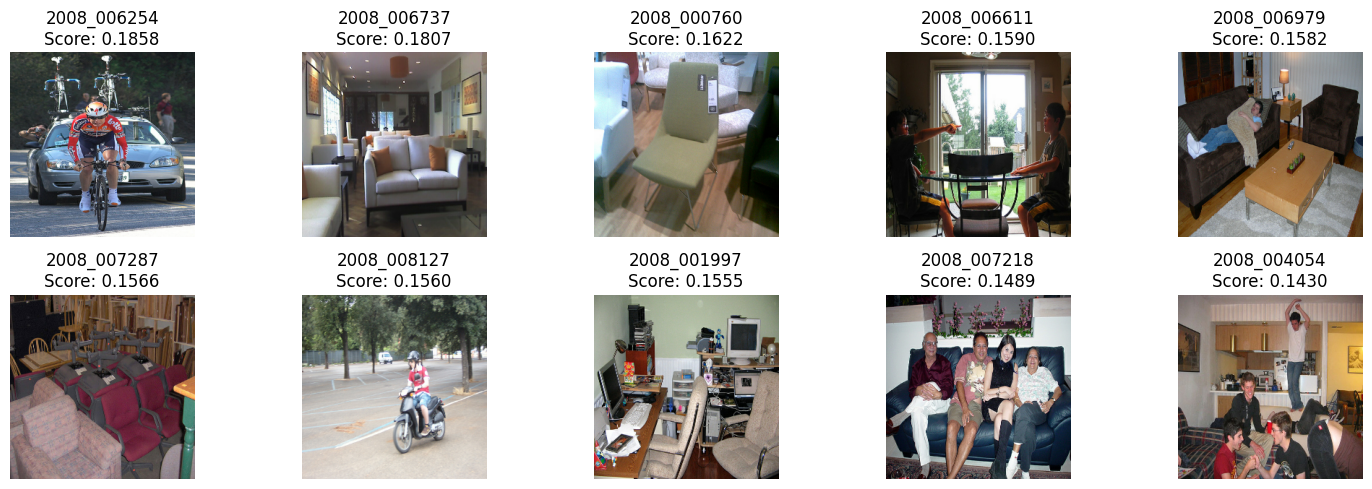

In [36]:
print("\nDisplaying Top-10 Images from VGG16 model:")
top10_vgg = get_top_k_images(trained_models['vgg16'], test_dataset, k=10)
display_top_images(top10_vgg)


Displaying Top-10 Images from ResNet50 model:
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step


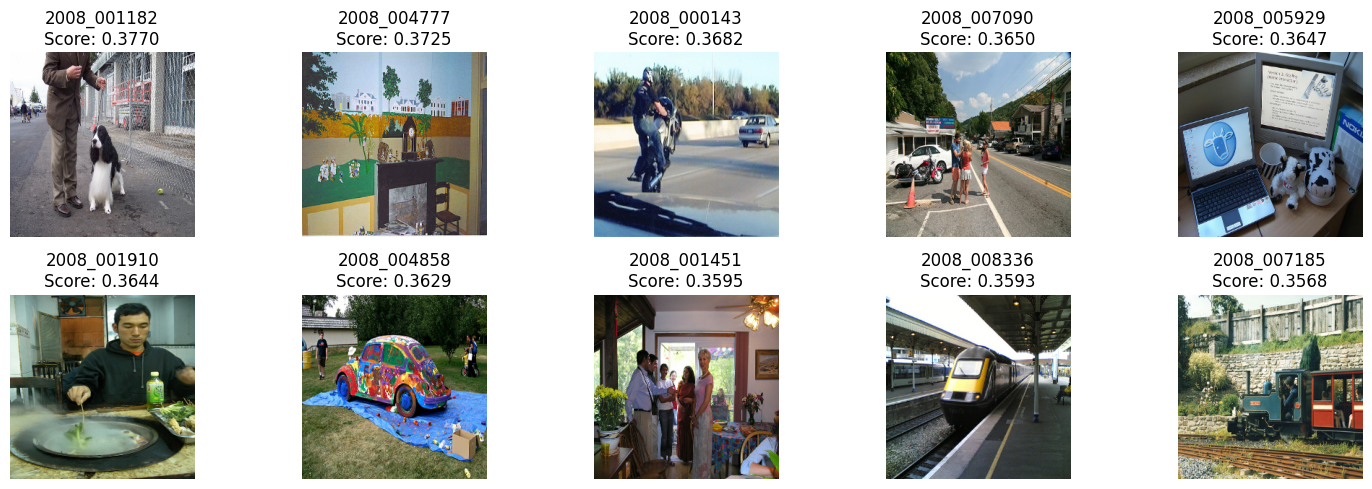

In [37]:
print("\nDisplaying Top-10 Images from ResNet50 model:")
top10_vgg = get_top_k_images(trained_models['resnet50'], test_dataset, k=10)
display_top_images(top10_vgg)


Displaying Top-10 Images from DenseNet121 model:
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step


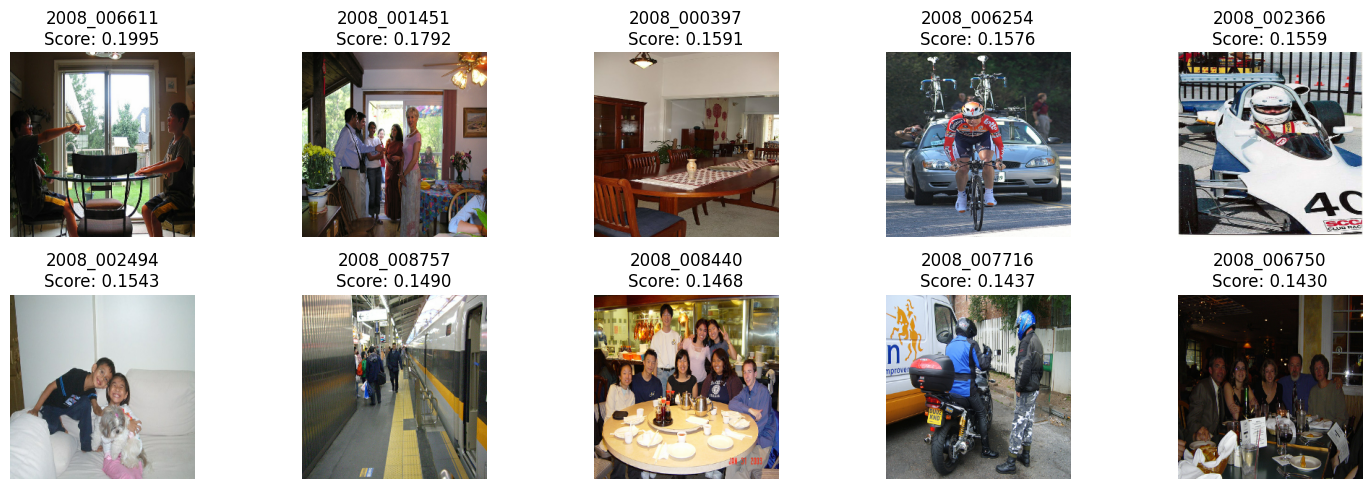

In [38]:
print("\nDisplaying Top-10 Images from DenseNet121 model:")
top10_vgg = get_top_k_images(trained_models['densenet121'], test_dataset, k=10)
display_top_images(top10_vgg)


Displaying Top-10 Images from VGG16 model:
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step


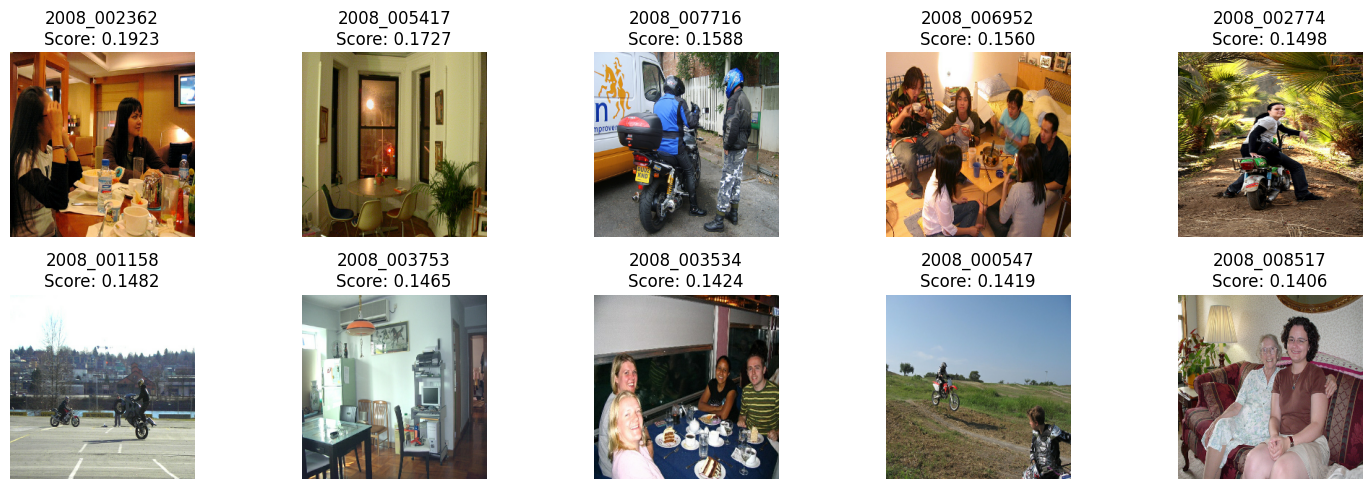

In [39]:
print("\nDisplaying Top-10 Images from VGG16 model:")
top10_vgg = get_top_k_images(trained_models['mobilenet_v2'], test_dataset, k=10)
display_top_images(top10_vgg)